# **Modelo de regresión robusta**
## Desarrollado por Jesus David Gomez Osorno
## Universidad de Antioquia

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
RUTA_DATA = '/content/drive/MyDrive/Monografía/data'
RUTA_DATA_MEDIANOS = RUTA_DATA + '/medianos'
RUTA_DATA_GRANDES = RUTA_DATA + '/grandes'
RUTA_RESULTADOS_MEDIANOS = RUTA_DATA + '/resultados/medianos'
RUTA_RESULTADOS_GRANDES = RUTA_DATA + '/resultados/grandes'

## 1. Caracteristicas

In [3]:
DEPARTAMENTO = 'DEPARTAMENTO'
MUNICIPIO = 'MUNICIPIO'
GRUPO_CULTIVO = 'GRUPO_CULTIVO'
CULTIVO = 'CULTIVO'
AREA_SEMBRADA = 'AREA_SEMBRADA'
AREA_COSECHADA = 'AREA_COSECHADA'
PRODUCCION = 'PRODUCCION'
ESTADO_FISICO_PRODUCCION = 'ESTADO_FISICO_PRODUCCION'
CICLO_CULTIVO = 'CICLO_CULTIVO'

In [4]:
columns = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_SEMBRADA,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

columns_feature = [
            DEPARTAMENTO,
            MUNICIPIO,
            GRUPO_CULTIVO,
            CULTIVO,
            AREA_COSECHADA,
            PRODUCCION,            
            ESTADO_FISICO_PRODUCCION,
            CICLO_CULTIVO
          ]

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

##Función de metricas

In [6]:
from sklearn.model_selection import cross_val_score # Método de validación cruzada para evaluar el desempeño un modelo
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score # Se llama a una clase llamada explained_variance_score, el cual es
                                                     # una métrica de varianza explicada
from sklearn.metrics import mean_absolute_error # Se llama a una clase llamada mean_absolute_error, el cual es
                                                # una métrica de error promedio absoluto
from sklearn.metrics import mean_gamma_deviance # 0.001 (Sensibilidad del modelo regresión)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_poisson_deviance                                            

def puntaje(X_Prueba_local, Y_Prueba_local, y_pred_local, estimador, name):
  Puntaje_1_R2 = estimador.score(X_Prueba_local, Y_Prueba_local) 

  # Error cuadrático medio
  Validacion_ECM = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 5, scoring = 'neg_mean_squared_error')
  Puntaje_2_ECM = np.array([Validacion_ECM.mean(), Validacion_ECM.std()]) 

  ## R Cuadrado
  Validacion_R2 = cross_val_score(estimador, X_Prueba_local, Y_Prueba_local, cv = 10, scoring = 'r2')
  Puntaje_3_R2 = np.array([Validacion_R2.mean(), Validacion_R2.std()]) 

  ## Varianza Explicada
  Puntaje_4 = explained_variance_score(Y_Prueba_local, y_pred_local) 
  ## ECM
  Puntaje_5 = mean_absolute_error(Y_Prueba_local, y_pred_local) 

  ## Pérdida media de regresión de la desviación de Poisson
  MN = MinMaxScaler(feature_range=(0, 1))

  Y_Prueba_R = Y_Prueba_local.values
  Y_Prueba_R = np.asarray(Y_Prueba_R)
  Y_merge = np.vstack([Y_Prueba_R, y_pred_local]).T
  Y_merge = MN.fit_transform(Y_merge)

  for _,n in enumerate(np.arange(0, Y_merge.shape[0])):
    if Y_merge[n,0] == 0:
      Y_merge[n,0] = 0.0001
    if Y_merge[n,1] == 0:
      Y_merge[n,1] = 0.0001

  Puntaje_6 = mean_poisson_deviance(Y_merge[:,0], Y_merge[:,1]) 
  Puntaje_7 = mean_gamma_deviance(Y_merge[:,0], Y_merge[:,1])

  return {'NOMBRE': name, 
          'R2_MODEL': Puntaje_1_R2, 
          'CROSS_ECM': Puntaje_2_ECM[0], 
          'CROSS_ECM_DE': Puntaje_2_ECM[1], 
          'CROSS_R2': Puntaje_3_R2[0], 
          'CROSS_R2_DE': Puntaje_3_R2[1],
          'VARIANZA_EXPL': Puntaje_4,
          'MAE': Puntaje_5,
          'MAE_POISSON': Puntaje_6,
          'MAE_GAMMA': Puntaje_7}


## Función grafica mejor

In [7]:
from sklearn.linear_model import LinearRegression # Algoritmo para crear el modelo de regresión lineal múltiple
from sklearn.linear_model import RANSACRegressor # Se llama a una clase llamada RANSACRegressor para aplicar el método 
                                                 # RANSAC o random sample consensus

def grafica_mejor(url, opc):
  data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
  data_after_features = data_after[columns_feature]
  data_after_estimados = data_after[AREA_SEMBRADA]

  X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

  LR = LinearRegression()
  LR.fit(X_Entrenamiento, Y_Entrenamiento)

  MR = RANSACRegressor(base_estimator = LR, max_trials = 1000, residual_threshold = opc) # A partir del modelo de regresión lineal múltiple, se aumenta la robustez con el método RANSAC
  MR.fit(X_Entrenamiento, Y_Entrenamiento)
  
  Y_pred = MR.predict(X_Prueba)

  fig = plt.figure(figsize=(12,8))
  line_1 = plt.plot(np.arange(len(Y_Prueba)), Y_Prueba, color = 'g', label='Y original') 
  line_2 = plt.plot(np.arange(len(Y_Prueba)), Y_pred, color = 'r', label='Y estimada por el modelo con regresión robusta') 
  plt.axhline(0, color="black") # Elegir color de la linea horizontal de referencia
  plt.legend()
  plt.title('Comparación entre Y salida original vs Y salida del modelo con regresión robusta') # Titulo de la gráfica
  plt.xlabel('muestras') # Etiqueta del eje x
  plt.ylabel('y') # Etiqueta del eje y

  plt.show() # Mostrar gráfica

##Función de guardadado de resultados

In [8]:
from os.path import exists

def guardaResultados(url, filename, data):
  if not exists(url):
    np.savetxt(url, data, delimiter=',')

  data_after = pd.read_csv(url, header = None, index_col= False, names = columns_resultados)
  data_after = data_after[data_after['NOMBRE'] == filename ]

  if not len(data_after) > 0:
    print('dentro')
    np.savetxt(url, data, delimiter=',', fmt="%s")
  
  return len(data_after) > 0, pd.concat([data, data_after]);

##Medianos

In [9]:
import os
from sklearn.model_selection import train_test_split # Esta clase realiza la partición de datos en entrenamiento y prueba

columns_resultados = ['NOMBRE', 'CONFIG', 'R2_MODEL', 'CROSS_ECM', 'CROSS_ECM_DE', 'CROSS_R2', 'CROSS_R2_DE', 'VARIANZA_EXPL', 'MAE', 'MAE_POISSON', 'MAE_GAMMA']

In [10]:
df_resultados_medianos = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_MEDIANOS):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_MEDIANOS + '/regresion_robusta.csv', filename, df_resultados_medianos )
      df_resultados_medianos = new_data
      if not is_save:
        url = RUTA_DATA_MEDIANOS + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]
        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

        opcionesRobusta = [0.05, 0.1, 0.15, 0.2, 0.25]
        # no se observa mucho cambio con base en el mae y desvicion stadar
        for opc in opcionesRobusta:
          LR = LinearRegression()
          LR.fit(X_Entrenamiento, Y_Entrenamiento)

          MR = RANSACRegressor(base_estimator = LR, max_trials = 1000, residual_threshold = opc) # A partir del modelo de regresión lineal múltiple, se aumenta la robustez con el método RANSAC
          MR.fit(X_Entrenamiento, Y_Entrenamiento)
          
          Y_pred = MR.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, MR, filename)
          result['CONFIG'] = opc
          df_resultados_medianos = df_resultados_medianos.append(result, ignore_index=True)

robusto_original.csv
dentro
estandar_original.csv
dentro
min_max_original.csv
dentro
max_normalizacion_original.csv
dentro
robusto_lof_euclidean_5.csv
dentro
robusto_lof_minkowski_5.csv
dentro
robusto_lof_manhattan_5.csv
dentro
robusto_lof_euclidean_7.csv
dentro
robusto_lof_minkowski_7.csv
dentro
robusto_lof_manhattan_7.csv
dentro
robusto_lof_euclidean_9.csv
dentro
robusto_lof_minkowski_9.csv
dentro
robusto_lof_manhattan_9.csv
dentro
robusto_lof_euclidean_11.csv
dentro
robusto_lof_minkowski_11.csv
dentro
robusto_lof_manhattan_11.csv
dentro
estandar_lof_euclidean_5.csv
dentro
estandar_lof_minkowski_5.csv
dentro
estandar_lof_manhattan_5.csv
dentro
estandar_lof_euclidean_7.csv
dentro
estandar_lof_minkowski_7.csv
dentro
estandar_lof_manhattan_7.csv
dentro
estandar_lof_euclidean_9.csv
dentro
estandar_lof_minkowski_9.csv
dentro
estandar_lof_manhattan_9.csv
dentro
estandar_lof_euclidean_11.csv
dentro
estandar_lof_minkowski_11.csv
dentro
estandar_lof_manhattan_11.csv
dentro
min_max_lof_euclide

In [11]:
pd.set_option("min_rows", 20)
df_resultados_medianos_sort = df_resultados_medianos.sort_values('MAE', False)
df_resultados_medianos_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
555,min_max_isf_400_0_2.csv,0.05,0.835222,-0.000010,1.489848e-06,0.833289,0.034275,0.835255,0.001844,0.041001,1.526411e+00
559,min_max_isf_400_0_2.csv,0.25,0.835214,-0.000010,1.489862e-06,0.833337,0.034245,0.835248,0.001844,0.040983,1.511002e+00
558,min_max_isf_400_0_2.csv,0.20,0.835214,-0.000010,1.489852e-06,0.833337,0.034245,0.835248,0.001844,0.040983,1.511002e+00
557,min_max_isf_400_0_2.csv,0.15,0.835214,-0.000010,1.489862e-06,0.833337,0.034245,0.835248,0.001844,0.040983,1.511002e+00
556,min_max_isf_400_0_2.csv,0.10,0.835214,-0.000010,1.489862e-06,0.833337,0.034245,0.835248,0.001844,0.040983,1.511002e+00
480,min_max_isf_100_0_2.csv,0.05,0.837924,-0.000010,5.016961e-07,0.837455,0.015207,0.837928,0.001860,0.029248,3.663281e+00
481,min_max_isf_100_0_2.csv,0.10,0.837910,-0.000010,5.012124e-07,0.837448,0.015195,0.837914,0.001861,0.029049,4.991114e+00
482,min_max_isf_100_0_2.csv,0.15,0.837917,-0.000010,5.012124e-07,0.837448,0.015195,0.837920,0.001861,0.029109,4.900262e+00
483,min_max_isf_100_0_2.csv,0.20,0.837917,-0.000010,5.011872e-07,0.837448,0.015195,0.837920,0.001861,0.029109,4.900262e+00
484,min_max_isf_100_0_2.csv,0.25,0.837917,-0.000010,5.012124e-07,0.837448,0.015195,0.837920,0.001861,0.029109,4.900262e+00


### Mejor resultado

In [12]:
df_resultados_medianos_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
555,min_max_isf_400_0_2.csv,0.05,0.835222,-0.00001,0.000001,0.833289,0.034275,0.835255,0.001844,0.041001,1.526411


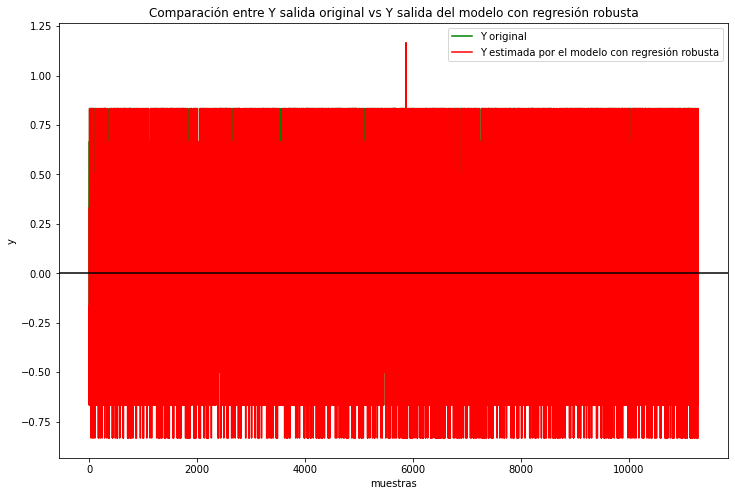

In [13]:
url = RUTA_DATA_MEDIANOS + '/' + df_resultados_medianos_sort.at[0,'NOMBRE']
opc = df_resultados_medianos_sort.at[0,'CONFIG']
grafica_mejor(url, opc)

## Grandes

In [14]:
df_resultados_grandes = pd.DataFrame(columns=columns_resultados, index=None)

for filename in os.listdir(RUTA_DATA_GRANDES):
    if filename.endswith("csv"): 
      print(filename)
      is_save, new_data = guardaResultados(RUTA_RESULTADOS_GRANDES + '/regresion_robusta.csv', filename, df_resultados_grandes )
      df_resultados_grandes = new_data
      if not is_save:
        url = RUTA_DATA_GRANDES + '/' + filename
        data_after = pd.read_csv(url, header = None, index_col= False, names = columns)
        data_after_features = data_after[columns_feature]
        data_after_estimados = data_after[AREA_SEMBRADA]
        X_Entrenamiento, X_Prueba, Y_Entrenamiento, Y_Prueba = train_test_split(data_after_features, data_after_estimados, test_size = 0.2, random_state = 17)

        opcionesRobusta = [0.05, 0.1, 0.15, 0.2, 0.25]
        # no se observa mucho cambio con base en el mae y desvicion stadar
        for opc in opcionesRobusta:
          LR = LinearRegression()
          LR.fit(X_Entrenamiento, Y_Entrenamiento)

          MR = RANSACRegressor(base_estimator = LR, max_trials = 1000, residual_threshold = opc) # A partir del modelo de regresión lineal múltiple, se aumenta la robustez con el método RANSAC
          MR.fit(X_Entrenamiento, Y_Entrenamiento)
          
          Y_pred = MR.predict(X_Prueba)

          result = puntaje(X_Prueba, Y_Prueba, Y_pred, MR, filename)
          result['CONFIG'] = opc
          df_resultados_grandes = df_resultados_grandes.append(result, ignore_index=True)

robusto_original.csv
dentro
estandar_original.csv
dentro
min_max_original.csv
dentro
max_normalizacion_original.csv
dentro
robusto_lof_euclidean_5.csv
dentro
robusto_lof_minkowski_5.csv
dentro
robusto_lof_manhattan_5.csv
dentro
robusto_lof_euclidean_7.csv
dentro
robusto_lof_minkowski_7.csv
dentro
robusto_lof_manhattan_7.csv
dentro
robusto_lof_euclidean_9.csv
dentro
robusto_lof_minkowski_9.csv
dentro
robusto_lof_manhattan_9.csv
dentro
robusto_lof_euclidean_11.csv
dentro
robusto_lof_minkowski_11.csv
dentro
robusto_lof_manhattan_11.csv
dentro
estandar_lof_euclidean_5.csv
dentro
estandar_lof_minkowski_5.csv
dentro
estandar_lof_manhattan_5.csv
dentro
estandar_lof_euclidean_7.csv
dentro
estandar_lof_minkowski_7.csv
dentro
estandar_lof_manhattan_7.csv
dentro
estandar_lof_euclidean_9.csv
dentro
estandar_lof_minkowski_9.csv
dentro
estandar_lof_manhattan_9.csv
dentro
estandar_lof_euclidean_11.csv
dentro
estandar_lof_minkowski_11.csv
dentro
estandar_lof_manhattan_11.csv
dentro
min_max_lof_euclide

In [15]:
pd.set_option("min_rows", 20)
df_resultados_grandes_sort = df_resultados_grandes.sort_values('MAE', False)
df_resultados_grandes_sort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only
  


,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
150,min_max_lof_manhattan_5.csv,0.05,0.959440,-0.000054,0.000020,0.945680,0.034046,0.959520,0.001238,0.001288,0.960675
190,min_max_lof_minkowski_11.csv,0.05,0.955222,-0.000034,0.000016,0.921915,0.078536,0.955282,0.001254,0.001423,0.894379
155,min_max_lof_euclidean_7.csv,0.05,0.946050,-0.000049,0.000010,0.940867,0.039014,0.946121,0.001292,0.001772,1.026473
186,min_max_lof_euclidean_11.csv,0.10,0.958341,-0.000037,0.000021,0.953837,0.027671,0.958348,0.001309,0.001655,1.007318
151,min_max_lof_manhattan_5.csv,0.10,0.962974,-0.000036,0.000023,0.949611,0.046330,0.962985,0.001314,0.001805,1.206280
192,min_max_lof_minkowski_11.csv,0.15,0.958581,-0.000033,0.000014,0.953623,0.027594,0.958586,0.001318,0.001677,1.017216
160,min_max_lof_minkowski_7.csv,0.05,0.951655,-0.000097,0.000078,0.922971,0.041098,0.951659,0.001319,0.001502,0.908349
140,min_max_lof_euclidean_5.csv,0.05,0.947307,-0.000064,0.000045,0.935955,0.069080,0.947401,0.001323,0.001946,1.082750
193,min_max_lof_minkowski_11.csv,0.20,0.958529,-0.000057,0.000056,0.956859,0.027999,0.958533,0.001325,0.001706,1.028643
195,min_max_lof_manhattan_11.csv,0.05,0.957111,-0.000037,0.000024,0.954139,0.032182,0.957131,0.001325,0.002083,1.122802


### Mejor resultado

In [16]:
df_resultados_grandes_sort.head(1)

,NOMBRE,CONFIG,R2_MODEL,CROSS_ECM,CROSS_ECM_DE,CROSS_R2,CROSS_R2_DE,VARIANZA_EXPL,MAE,MAE_POISSON,MAE_GAMMA
150,min_max_lof_manhattan_5.csv,0.05,0.95944,-0.000054,0.00002,0.94568,0.034046,0.95952,0.001238,0.001288,0.960675


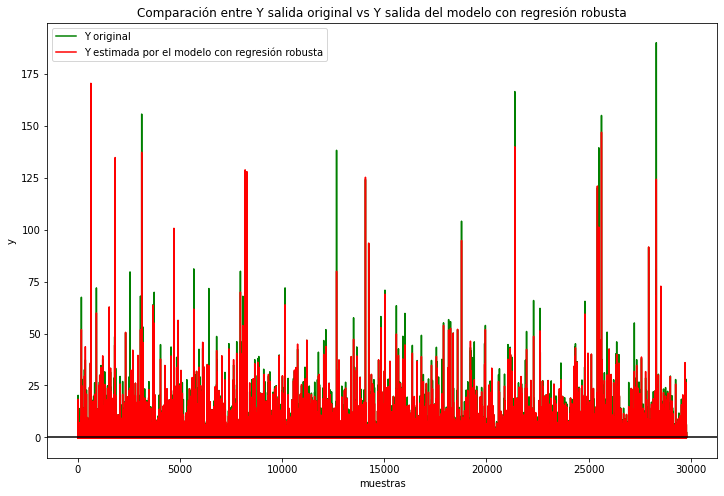

In [17]:
url = RUTA_DATA_GRANDES + '/' + df_resultados_grandes_sort.at[0,'NOMBRE']
opc = df_resultados_grandes_sort.at[0,'CONFIG']
grafica_mejor(url, opc)